In [1]:
import os
import time
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy.sparse

# Customize plot colors for dark backgrounds
%matplotlib inline
mpl.rcParams['axes.edgecolor'] = 'grey'
mpl.rcParams['grid.color'] = '#66CCCC'
mpl.rcParams['text.color'] = '#0EBFE9'
mpl.rcParams['xtick.color'] = '#66CCCC'
mpl.rcParams['ytick.color'] = '#66CCCC'
mpl.rcParams['axes.labelcolor'] = '#0EBFE9'

import IPython.utils.path
DATA_DIR = os.path.join(IPython.utils.path.get_home_dir(), 'work/recog/resources/')
print 'Data directory:', DATA_DIR
dataset_name = 'recom'

Data directory: /Users/kikohs/work/recog/resources/


In [2]:
data = sp.io.loadmat(os.path.join(DATA_DIR, 'recom_data.mat'))

### Description

- A_gt = A ground truth
- B_gt = B ground truth
- C = ground truth
- A init = Initialisation A because the problem is non convex
- B init = Initialisation B
- KA, KB = graph gradient operators for A, B
- O = Omega = observation mask
- WB = graph of B (songs)
- perc: percentage of observation
- norm A: norm of operator A


In [5]:
def soft_thresholding(data, value, substitute=0):
    mvalue = -value
    cond_less = np.less(data, value)
    cond_greater = np.greater(data, mvalue)
    data = np.where(cond_less & cond_greater, substitute, data)
    data = np.where(cond_less, data + value, data)
    data = np.where(cond_greater, data - value, data)
    return data


def init(nb_row, nb_col, rank):
    a = np.random.random((nb_row, rank))
    b = np.random.random((rank, nb_col))
    a /= np.linalg.norm(a, axis=0) 
    b = (b.T / np.linalg.norm(b, axis=1)).T
    return a, b


def graph_gradient_operator(g):
    # TODO
    return None


def proximal_training(C, WA, WB, O, rank, theta_tv=1e-4*5, nb_iter_max=20):
    
    def update_step(nb_iter, a, b):
        b = update_factor(b, a, KB, normKB, O, OC)
        a = update_factor(a.T, b.T, KA, normKA, O.T, OC.T).T
        return a, b
    
    def update_factor(X, Y, K, normK, omega, OC):
        # L2-norm of columns
        X /= np.linalg.norm(X, axis=0)
        Y = (Y.T / np.linalg.norm(Y, axis=1)).T
        
        # Primal variable
        Xb = X  
        Xold = X
        # First dual variable
        P1 = Y.dot(X)
        # Second dual variable
        P2 = K.dot(X.T)

        # 2-norm largest sigular value
        normY = np.linalg.norm(Y, 2)
        
        # Primal-dual parameters
        gamma1 = 1e-1;
        gamma2 = 1e-1;
        
        # init timestamps
        sigma1 = 1.0 / normY;
        tau1 = 1.0 / normY;
        sigma2 = 1.0 / normK;
        tau2 = 1.0 / normK;
        

        # TODO: create better loop
        inner_loop = 1000
        for j in xrange(inner_loop):
            
            # update P1 (NMF part)
            P1 += sigma1 * Y.dot(Xb)
            t = (P1 - omega)**2 + 4 * sigma1 * OC
            P1 = 0.5 * (P1 + omega - np.sqrt(t))
            
            # update P2 (TV)
            P2 += sigma2 * K.dot(Xb.T)
            P2 -= sigma2 * soft_thresholding(P2 / sigma2, theta_tv / sigma2)
            
            # new primal variable
            X = X - tau1 * (Y.T.dot(P1)) - tau2 * (K.T.dot(P2)).T
            # set negative values to 0 (element wise)
            X = np.maximum(X, 0)
            
            # Acceleration, update timesteps
            theta1 = 1. / np.sqrt(1 + 2 * gamma1 * tau1)
            tau1 = tau1 * theta1
            sigma1 = sigma1 / theta1
            theta2 = 1./ np.sqrt( 1 + 2 * gamma2 * tau2)
            tau2 = tau2 * theta2
            sigma2 = sigma2 / theta2
            
            # update primal variable for acceleration
            t = X - Xold
            Xb = X + 0.5 * theta1 * t + 0.5 * theta2 * t
            
            # update Xold
            Xold = X
    
        return X

#     A, B = init(C.shape[0], C.shape[1], rank)
    # TEMP to verify with matlab
    A = data['Ainit'].copy()
    B = data['Binit'].copy()
      
#     KA = graph_gradient_operator(WA)
#     KB = graph_gradient_operator(WB)
    KA = data['KA']
    KB = data['KB']
    
    # 2-norm largest sigular value
    normA = np.linalg.norm(A, 2)
    normB = np.linalg.norm(B, 2)    
    
    # For sparse matrix
    _, normKA, _ = sp.sparse.linalg.svds(KA, 1)
    _, normKB, _ = sp.sparse.linalg.svds(KB, 1)
    
    # Mask over rating matrix, computed once
    OC = O * C
    
    # TODO better iter
    for i in range(nb_iter_max):
        A, B = update_step(i, A, B)
        print 'Err: ', np.linalg.norm(C - A.dot(B))
    
    return A, B

In [6]:
D, F = proximal_training(data['C'], None, data['WB'], data['O'], data['A'].shape[1])

Err:  9.80610791208
Err:  9.76854239806
Err:  9.74462279063
Err:  9.7849765716
Err:  9.73184026852


KeyboardInterrupt: 

In [7]:
d, f = proximal_training(data['C'], None, data['WB'], data['O'], data['A'].shape[1])

Err:  9.80610791208
Err:  9.76854239806
Err:  9.74462279063
Err:  9.7849765716
Err:  9.73184026852


KeyboardInterrupt: 

### Plot results

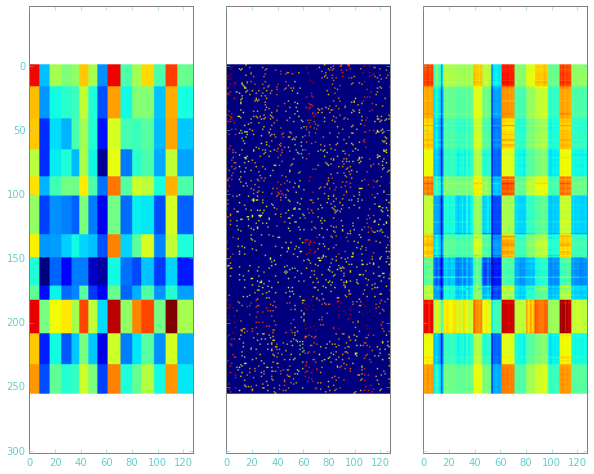

In [173]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches((10, 8))
ax1.imshow(data['C'])
ax2.imshow(data['C'] * data['O'])
ax3.imshow(A.dot(B))